In [89]:
#import necessary libraries
import xarray as xr
import geopandas as gpd
import READ_EDAB_Utilities_py as reupy
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import rioxarray
from shapely.geometry import mapping

In [137]:
#import the data
bt = xr.open_dataset('C:/Users/Laura.Gruenburg/Desktop/Projects/MOM6_Validation/Lobster_Areas/ocean_daily.19930101-20191231.tob.nc')
depths = xr.open_dataset('C:/Users/Laura.Gruenburg/Desktop/Projects/MOM6_Validation/ocean_static_deptho.nc')

In [8]:
#import the shapefiles
epu = gpd.read_file('EPU_shape/EPU_NOESTUARIES.shp')

In [87]:
# Haley's function which allows you to clip to multiple areas at the same time
def clip_xr(ds, lon_name, lat_name, shp, projection=None):
    ds.rio.set_spatial_dims(x_dim=lon_name, y_dim=lat_name, inplace=True)
    try:
        ds.rio.write_crs(projection, inplace=True)
    except:
        ds.rio.write_crs("EPSG:4326", inplace=True)
    clipped = ds.rio.clip(shp.geometry.apply(mapping), shp.crs, drop=True)
    return clipped

In [139]:
#lon needs to be in degrees east for the clip_xr function
bt_m6 = bt.assign_coords(lon = -1*( 360 - bt.lon))
depths_m6 = depths.assign_coords(lon = -1*(360 - depths.lon))

In [140]:
# Crop to the shape
bt_neus = clip_xr(bt_m6.sel(lat = slice(34, 46), lon = slice(-77, -64)), 'lon', 'lat', epu)
depth_neus = clip_xr(depths_m6.sel(lat = slice(34, 46), lon = slice(-77, -64)), 'lon', 'lat', epu)


In [96]:
# Do the thermal limits calculations
less_than_half = (bt_neus.tob < 0.5).groupby('time.year').sum('time')
thermal_ds = xr.Dataset(data_vars = {'n_0.5': (['year','lat','lon'], less_than_half.data)},
                        coords = {'year': less_than_half.year.values,
                                  'lat': less_than_half.lat.values,
                                  'lon': less_than_half.lon.values})

for i in np.arange(1,30.5, 0.5):
    label = 'n_' + str(i)
    thermal_ds[label] = (['year','lat','lon'], (bt_neus.tob < i).groupby('time.year').sum('time').data)
    

In [125]:
# Save as yearly netcdfs
for i in thermal_ds.year:
    thermal_ds.sel(year = i.values).to_netcdf('test_thermal_habitat_gridded_NEUS_' + str(i.values) + '.nc')

In [126]:
## Looking at the data

In [129]:
test = xr.open_dataset('C:/Users/Laura.Gruenburg/Desktop/Projects/thermal_habitat_gridded_1994_SOE2025.nc')

In [130]:
test

<xarray.Dataset> Size: 15MB
Dimensions:    (longitude: 193, latitude: 157, time: 1)
Coordinates:
  * longitude  (longitude) float64 2kB -78.0 -77.92 -77.83 ... -62.08 -62.0
  * latitude   (latitude) float64 1kB 47.0 46.92 46.83 ... 34.17 34.08 34.0
  * time       (time) datetime64[ns] 8B 1994-01-01
Data variables: (12/61)
    nday_0_5   (time, latitude, longitude) timedelta64[ns] 242kB ...
    nday_1     (time, latitude, longitude) timedelta64[ns] 242kB ...
    nday_1_5   (time, latitude, longitude) timedelta64[ns] 242kB ...
    nday_2     (time, latitude, longitude) timedelta64[ns] 242kB ...
    nday_2_5   (time, latitude, longitude) timedelta64[ns] 242kB ...
    nday_3     (time, latitude, longitude) timedelta64[ns] 242kB ...
    ...         ...
    nday_28    (time, latitude, longitude) timedelta64[ns] 242kB ...
    nday_28_5  (time, latitude, longitude) timedelta64[ns] 242kB ...
    nday_29    (time, latitude, longitude) timedelta64[ns] 242kB ...
    nday_29_5  (time, latitude, longitude) timedelta64[ns] 242kB ...
    nday_30    (time, latitude, longitude) timedelta64[ns] 242kB ...
    crs        timedelta64[ns] 8B ...
Attributes: (12/46)
    created_by:                 R packages ncdf4 and terra (version 1.7-78)
    date:                       2024-12-03 16:42:48
    acknowledgement:            The data are sponsored by NOAA and may be fre...
    contributor_name:           Ecosystem Dynamics and Assessment Branch
    contributor_institution:    DOC | NOAA | National Marine Fisheries Servic...
    Conventions:                CF-1.6, COARDS, ACDD-1.3
    ...                         ...
    summary:                    Each year the number of days where bottom tem...
    time_coverage_resolution:   P0Y0M0D1
    title:                      Number of days bottom temperature (GLORYS12V1...
    sea_name:                   Northwest Atlantic Ocean (limit-40 W)
    time_coverage_start:        1994-01-01
    time_coverage_end:          1994-12-31

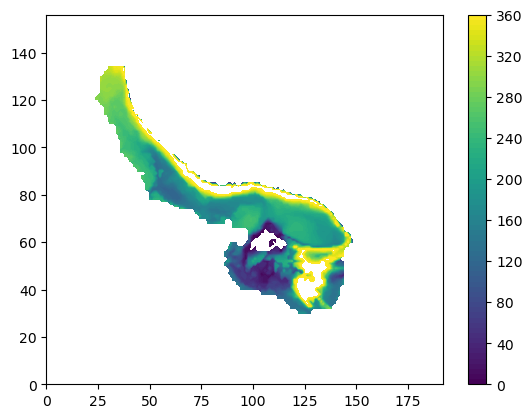

In [122]:
plt.contourf(test.nday_8[0,:,:].values.astype('float')/86400000000000,levels =np.arange(0,365,5) )
plt.colorbar()

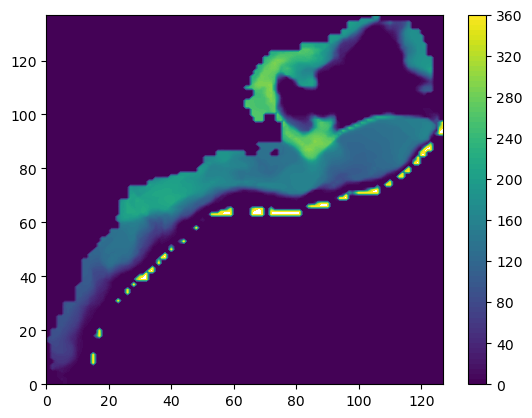

In [123]:
plt.contourf(thermal_ds['n_8.0'][1,:,:], levels = np.arange(0,365,5))
plt.colorbar()